In [1]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('/kaggle/input/ipinyou-season-3/parsed_final_data_season_3.csv')
test_df = pd.read_csv('/kaggle/input/ipinyou-season-3/final_test_data_season_3.csv')

/tmp/ipykernel_20/616515770.py:1: DtypeWarning: Columns (15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('/kaggle/input/ipinyou-season-3/parsed_final_data_season_3.csv')


In [3]:
train_df = train_df.drop('Unnamed: 0', axis=1)
test_df = test_df.drop('Unnamed: 0', axis=1)

In [4]:
train_df = train_df.fillna(value=False)

/tmp/ipykernel_20/1533110392.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df = train_df.fillna(value=False)


In [5]:
pairs_for_union = [('weekend', 'weekday'), ('city_id', 'weekday'), ('browser','is_male'),
                  ('city_id', 'ad_slot_format'), 
                  ('weekend', 'browser'), ('region_id', 'is_in_market')]

In [6]:
new_feat_names = []
for f1, f2 in pairs_for_union:
    new_name = f"{f1}__{f2}"
    new_feat_names.append(new_name)
    for df in [train_df, test_df]:
        df[new_name] = df[f1].astype(str) + "_" + df[f2].astype(str)

In [7]:
target_column = 'click'
categorical_features = [
    'region_id', 'city_id', 'ad_slot_visibility', 'ad_slot_format',
    'creative_id', 'advertiser_id', 'part_of_day', 'weekday', 'weekend',
    'os', 'browser', 'is_in_market', 'is_male'
] + new_feat_names
feature_columns = categorical_features + ["ad_slot_screen_share"]

In [8]:
class_counts = train_df[target_column].value_counts()
class_counts

click
False    21329922
True        11673
Name: count, dtype: int64

In [9]:
class_0_count = class_counts.get(0, 1)
class_1_count = class_counts.get(1, 1)

/tmp/ipykernel_20/780349676.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_0_count = class_counts.get(0, 1)
/tmp/ipykernel_20/780349676.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_1_count = class_counts.get(1, 1)


In [10]:
total_count = class_0_count + class_1_count
class_weights = [total_count / class_0_count, total_count / class_1_count]

In [11]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.6, random_state=42, stratify=train_df[target_column])

In [12]:
train_pool = Pool(data=train_df[feature_columns],
                  label=train_df[target_column],
                  cat_features=categorical_features)

In [13]:
test_pool = Pool(data=test_df[feature_columns],
                 label=test_df[target_column],
                 cat_features=categorical_features)

In [14]:
val_pool = Pool(data=val_df[feature_columns],
                 label=val_df[target_column],
                 cat_features=categorical_features)

0:	learn: 0.6731893	test: 0.6737179	best: 0.6737179 (0)	total: 181ms	remaining: 17.9s
1:	learn: 0.6558234	test: 0.6569770	best: 0.6569770 (1)	total: 286ms	remaining: 14s
2:	learn: 0.6363943	test: 0.6381032	best: 0.6381032 (2)	total: 382ms	remaining: 12.4s
3:	learn: 0.6117721	test: 0.6137753	best: 0.6137753 (3)	total: 475ms	remaining: 11.4s
4:	learn: 0.5980465	test: 0.6004980	best: 0.6004980 (4)	total: 571ms	remaining: 10.9s
5:	learn: 0.5877795	test: 0.5906629	best: 0.5906629 (5)	total: 657ms	remaining: 10.3s
6:	learn: 0.5781419	test: 0.5821659	best: 0.5821659 (6)	total: 744ms	remaining: 9.88s
7:	learn: 0.5695961	test: 0.5738742	best: 0.5738742 (7)	total: 829ms	remaining: 9.54s
8:	learn: 0.5594058	test: 0.5639202	best: 0.5639202 (8)	total: 915ms	remaining: 9.25s
9:	learn: 0.5514271	test: 0.5562684	best: 0.5562684 (9)	total: 1s	remaining: 9.05s
10:	learn: 0.5377049	test: 0.5425684	best: 0.5425684 (10)	total: 1.09s	remaining: 8.84s
11:	learn: 0.5320372	test: 0.5370480	best: 0.5370480 (11)

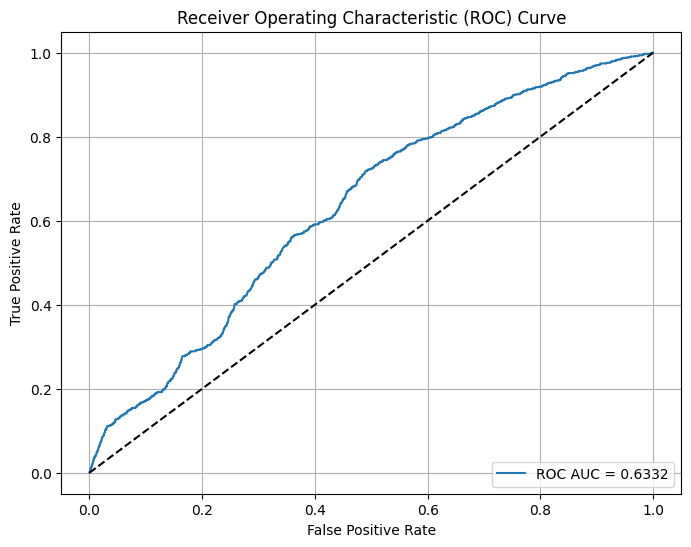

In [15]:
model = CatBoostClassifier(iterations=100, 
                           learning_rate=0.05, 
                           depth=5, 
                           task_type='GPU',
                           loss_function='Logloss',
                           class_weights=class_weights,
                           eval_metric='Logloss',
                           l2_leaf_reg=4)

model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, verbose=True)

predictions = model.predict_proba(test_pool)[:, 1]

roc_auc = roc_auc_score(test_df[target_column], predictions)
print(f"ROC AUC Score: {roc_auc:.4f}")

fpr, tpr, thresholds = roc_curve(test_df[target_column], predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

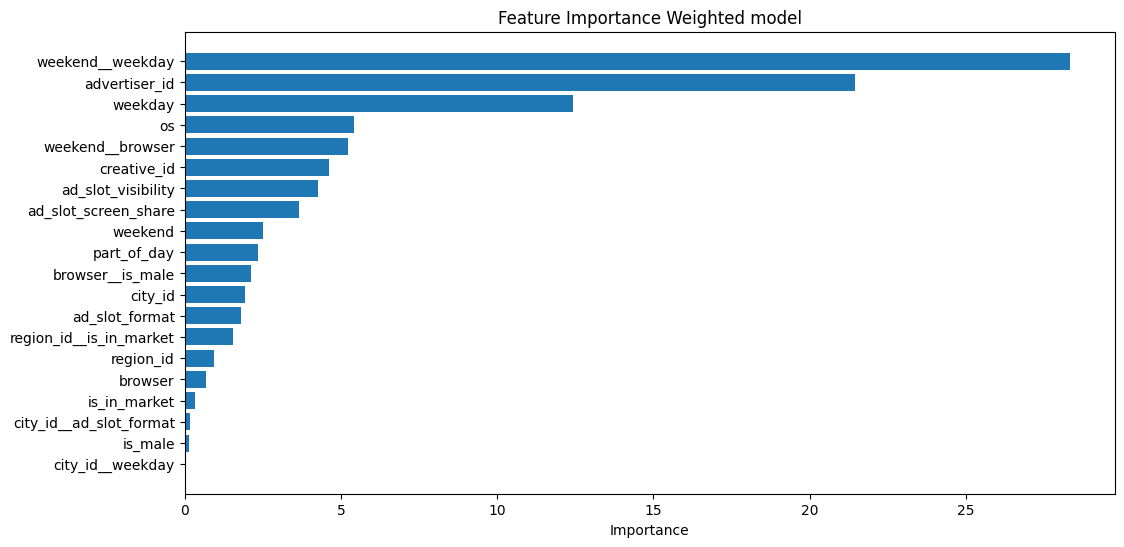

In [16]:
feature_importances = model.get_feature_importance(train_pool)
feature_importances_df = pd.DataFrame({'Feature': feature_columns, 'Importance': feature_importances})

feature_importances_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance Weighted model')
plt.gca().invert_yaxis()
plt.show()